In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
percent_of_side = 0.1

In [2]:
_, blue = cv2.imreadmulti('data/Blue-34a-dbl_0002.tiff', [], cv2.IMREAD_UNCHANGED)
_, red = cv2.imreadmulti('data/Red-34a-dbl_0002.tiff', [], cv2.IMREAD_UNCHANGED)
_, composite = cv2.imreadmulti('data/Composite-34a-dbl_0002.tiff', [], cv2.IMREAD_GRAYSCALE)

rows,cols = red[42].shape
M = np.float32([[1,0,10],[0,1,-3]])

# List of tuples of the form (blue, red) 
red_offset = [cv2.warpAffine(red[i],M,(cols,rows)) for i in range(len(red))]
blue_composite = [(blue[i], composite[i]) for i in range(len(composite))]

Create ellipse

In [3]:
comp = composite[15]
from library import helper
ellipse_percentage = 0.10 # need to keep this sufficiently small to make sure there is an outer and inner
clean_composite = helper._get_clean_composite(comp)
inner_mask = helper._get_ellipse_mask(clean_composite, ellipse_percentage=ellipse_percentage)

Get segmentation outlines

In [5]:
from library import plots
file = 15
# red limit
dat_red = np.load(f'red/{file}_seg.npy', allow_pickle=True).item()
img_red = dat_red['img']
# blue limit
dat_blue = np.load(f'blue/{file}_seg.npy', allow_pickle=True).item()
img_blue = dat_blue['img']

# Use cell_count to pick which channel has the most cells
cell_counts = plots.cell_count(file)
if cell_counts[0] > cell_counts[1]:
    outlines = plots.utils.outlines_list(dat_blue['masks'])
else:
    outlines = plots.utils.outlines_list(dat_red['masks'])

See which ones intersect with ellipse

In [6]:
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.affinity import scale
ellipse_percentage
(major, minor), center = helper._get_ellipse(clean_composite=clean_composite, ellipse_percentage=ellipse_percentage)

def create_ellipse_polygon(center, major_axis_length, minor_axis_length):
    point = Point(center)
    ellipse = scale(point, xfact=major_axis_length, yfact=minor_axis_length)
    return Polygon(list(ellipse.buffer(1.0).exterior.coords))
ellipse_polygon = create_ellipse_polygon(center, major_axis_length=major, minor_axis_length=minor)

Split into points_red and points_blue tuples with (inner, outer)

In [7]:
def get_inner_outer_polygons(polygons, ellipse):
    inner = []
    outer = []
    for polygon in polygons:
        shapely_polygon = Polygon(polygon)
        if shapely_polygon.intersects(ellipse):
            inner.append(polygon)
        else:
            outer.append(polygon)
    return inner, outer

inner, outer = get_inner_outer_polygons(outlines, ellipse_polygon)

<Figure size 640x480 with 0 Axes>

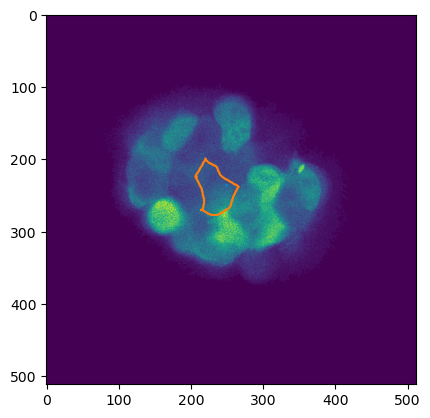

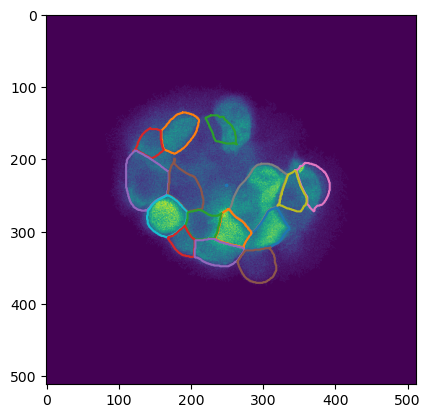

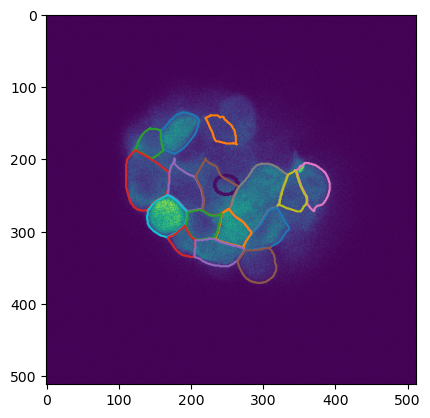

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot inner polygons on top of composite
plt.imshow(clean_composite)
plt.plot(*ellipse_polygon.exterior.xy)
for polygon in inner:
    plt.plot(*polygon.T)
plt.figure()
# Plot outer polygons on top of composite
plt.imshow(clean_composite)
plt.plot(*ellipse_polygon.exterior.xy)
for polygon in outer:
    plt.plot(*polygon.T)
# Plot outlines on top of composite
plt.figure()
img_blue_with_ellipse = img_blue.copy()
img_blue_with_ellipse = cv2.ellipse(img_blue_with_ellipse,
                            center,
                            (major, minor)
                            ,0, 0, 360, (255, 0, 0), 3)
plt.imshow(img_blue_with_ellipse)
for polygon in outlines:
    plt.plot(*polygon.T)
plt.figure()
# Plot ellipse on top of composite


Go through the inner and outer data for intrinsic and extrinsic noise

In [31]:
def get_means(img_blue, img_red, outlines):
    masked_imgs_red = plots.get_cell_masks(img_red,outlines)
    means_red = np.array([np.mean(plots.get_pixel_intensities(img_red, np.where(masked_img > 0))) for masked_img in masked_imgs_red])
    masked_imgs_blue = plots.get_cell_masks(img_blue,outlines)
    means_blue = np.array([np.mean(plots.get_pixel_intensities(img_blue, np.where(masked_img > 0))) for masked_img in masked_imgs_blue])
    return (means_red, means_blue)

In [35]:
get_means(img_blue, img_red, outer)

(array([ 677.18552253,  818.49827288,  729.63304348,  710.30310458,
         616.4542949 , 1213.62561335, 1326.23140681, 1103.89318342,
        1175.56207483, 2017.46303502, 1954.96743064,  930.1864831 ,
         739.98502994,  995.88280061,  372.64842615]),
 array([1365.58393113,  726.1840968 , 1014.75130435,  884.18159543,
         777.0989011 , 1026.13640824, 1396.3526516 ,  973.97540408,
        2002.55110733, 1144.62087379, 1739.72188634, 1005.13237139,
        1037.80079681, 1184.04713634,  568.53823814]))

Combine previous steps and 

/var/folders/9m/qcg58ft12w72z4h1j7s196w00000gn/T/ipykernel_79893/2737789260.py:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(center, 2 * major_axis_length, 2 * minor_axis_length, 0)


msis negative
alpha: 163152.81638584257, beta: -364527.6074667819, red_std: 621.832124797019, blue_std: 247.03211774501298, cov: -182263.80373339096 ms: -20551.540995335352
points_blue: [1191.03486529  870.26575342  586.30552764], points_red: [1098.07761352  946.60574949 2334.90808639]


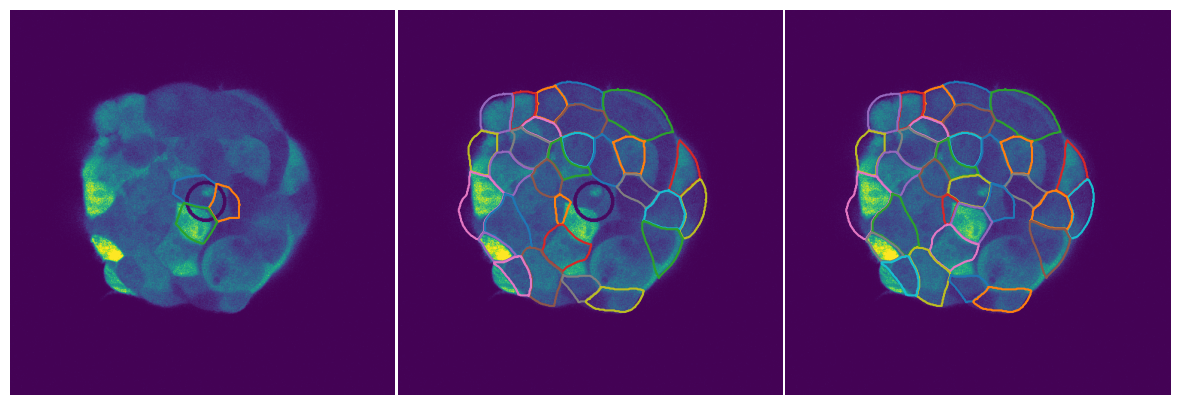

In [4]:
from library import plots
from matplotlib.patches import Ellipse
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.affinity import scale
import imageio
import os
ellipse_percentage = 0.10 # need to keep this sufficiently small to make sure there is an outer and inner
file = 15

def create_ellipse_polygon(center, major_axis_length, minor_axis_length):
    # first draw the ellipse using matplotlib
    ellipse = Ellipse(center, 2 * major_axis_length, 2 * minor_axis_length, 0) 
    vertices = ellipse.get_verts()     # get the vertices from the ellipse object
    ellipse = Polygon(vertices)        # Turn it into a polygon
    return ellipse

def get_inner_outer_polygons(polygons, ellipse):
    inner = []
    outer = []
    for polygon in polygons:
        shapely_polygon = Polygon(polygon)
        if shapely_polygon.intersects(ellipse):
            inner.append(polygon)
        else:
            outer.append(polygon)
    return inner, outer

def get_means(img_blue, img_red, outlines):
    masked_imgs_red = plots.get_cell_masks(img_red,outlines)
    means_red = np.array([np.mean(plots.get_pixel_intensities(img_red, np.where(masked_img > 0))) for masked_img in masked_imgs_red])
    masked_imgs_blue = plots.get_cell_masks(img_blue,outlines)
    means_blue = np.array([np.mean(plots.get_pixel_intensities(img_blue, np.where(masked_img > 0))) for masked_img in masked_imgs_blue])
    return (means_red, means_blue)

# Get segmentation outlines
# red limit
def inner_outer_scatter(file, data):
    dat_red = np.load(f'red/{file}_seg.npy', allow_pickle=True).item()
    img_red = dat_red['img']
    # blue limit
    dat_blue = np.load(f'blue/{file}_seg.npy', allow_pickle=True).item()
    img_blue = dat_blue['img']
    comp = img_blue + img_red

    # Create a figure with 3 subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1], 'wspace':0})

    # Turn comp to 8 bit 
    comp = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    clean_composite = helper._get_clean_composite(comp)

    # Use cell_count to pick which channel has the most cells
    cell_counts = plots.cell_count(file)
    outlines = plots.utils.outlines_list(dat_blue['masks']) if cell_counts[0] > cell_counts[1] else plots.utils.outlines_list(dat_red['masks'])

    # See which ones intersect with ellipse
    (major, minor), center = helper._get_ellipse(clean_composite=clean_composite, ellipse_percentage=ellipse_percentage)

    ellipse_polygon = create_ellipse_polygon(center, major_axis_length=major, minor_axis_length=minor)

    # Split into points_red and points_blue tuples with (inner, outer)
    inner, outer = get_inner_outer_polygons(outlines, ellipse_polygon)
    
    # Plot inner on top of composite
    img_blue_with_ellipse = img_blue.copy()
    img_blue_with_ellipse = cv2.ellipse(img_blue_with_ellipse,
                            center,
                            (major, minor)
                            ,0, 0, 360, (255, 0, 0), 3)
    ax1.imshow(img_blue_with_ellipse)
    for polygon in inner:
        ax1.plot(*polygon.T)

    # Plot outer on top of composite
    img_blue_with_ellipse = img_blue.copy()
    img_blue_with_ellipse = cv2.ellipse(img_blue_with_ellipse,
                            center,
                            (major, minor)
                            ,0, 0, 360, (255, 0, 0), 3)
    ax2.imshow(img_blue_with_ellipse)
    for polygon in outer:
        ax2.plot(*polygon.T)

    # Plot outlines and ellipse
    ax3.imshow(img_blue)
    for polygon in outlines:
        ax3.plot(*polygon.T)

    # Remove axis labels and tick marks from all subplots
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    # Go through the inner and outer data for intrinsic and extrinsic noise
    means_red_inner, means_blue_inner = get_means(img_blue, img_red, inner)
    means_red_outer, means_blue_outer = get_means(img_blue, img_red, outer)
    # Get intrinsic noise for inner, outer, and total
    intrinsic_inner, extrinsic_inner, total_inner = plots.get_noise_not_centered(means_red_inner, means_blue_inner)
    intrinsic_outer, extrinsic_outer, total_outer = plots.get_noise_not_centered(means_red_outer, means_blue_outer)
    
    data['intrinsics_outer'].append(intrinsic_outer)
    data['intrinsics_inner'].append(intrinsic_inner)
    data['extrinsics_outer'].append(extrinsic_outer)
    data['extrinsics_inner'].append(extrinsic_inner)
    data['totals_outer'].append(total_outer)
    data['totals_inner'].append(total_inner)

intrinsics_inner = []
intrinsics_outer = []
extrinsics_inner = []
extrinsics_outer = []
totals_inner = []
totals_outer = []
data = {}
data['intrinsics_outer'] = intrinsics_outer
data['intrinsics_inner'] = intrinsics_inner
data['extrinsics_outer'] = extrinsics_outer
data['extrinsics_inner'] = extrinsics_inner
data['totals_outer'] = totals_outer 
data['totals_inner'] = totals_inner 
inner_outer_scatter(52, data)
plt.show()

In [5]:
from library import plots
max_limit = max(plots.max_limit(red),plots.max_limit(blue))
print(max_limit)

3775.27693856999


In [6]:
# filenames = np.array([(12+i, 91-i) for i in range(len(red_offset)//2)])
filenames = [i for i in range(12, 92)]
name_of_file = 'plots/inner_outer_seg.gif'
plotting_function = inner_outer_scatter
filenames = filenames
intrinsics_inner = []
intrinsics_outer = []
extrinsics_inner = []
extrinsics_outer = []
totals_inner = []
totals_outer = []
data = {}
data['intrinsics_outer'] = intrinsics_outer
data['intrinsics_inner'] = intrinsics_inner
data['extrinsics_outer'] = extrinsics_outer
data['extrinsics_inner'] = extrinsics_inner
data['totals_outer'] = totals_outer 
data['totals_inner'] = totals_inner 
data["lim"] = max_limit
data["augment"] = True
# plots.create_gif_filenames(name_of_file, plotting_function, filenames, data)
plots.create_gif_left_right(name_of_file, plotting_function, 12, 91, [], data, no_images=True)

/var/folders/9m/qcg58ft12w72z4h1j7s196w00000gn/T/ipykernel_79893/2737789260.py:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(center, 2 * major_axis_length, 2 * minor_axis_length, 0)


msis negative
alpha: 50403.17090749765, beta: -1182.4496812577056, red_std: 1.8625090174020897, blue_std: 158.71730958208178, cov: -591.2248406288528 ms: -10.401092774437474
points_blue: [ 813.42181648 1130.85643564], points_red: [887.5713615  883.84634347]
msis negative
alpha: 434696.78911669535, beta: 440379.1332435017, red_std: 336.14232143361033, blue_std: 327.5243142289646, cov: 220189.56662175086 ms: -110076.21814719413
points_blue: [ 749.68133912 1404.72996758], points_red: [ 890.18193095 1562.46657382]
msis negative
alpha: 485125.24189949007, beta: 393520.4395732153, red_std: 313.4265383788279, blue_std: 425.6668436466608, cov: 196760.21978660766 ms: -61370.359169634234
points_blue: [ 920.26377663 1326.23140681 1954.96743064], points_red: [ 973.36420434 1396.3526516  1739.72188634]
msis negative
alpha: 364628.5750121367, beta: 221728.55042016812, red_std: 217.74096060458706, blue_std: 402.876509530839, cov: 110864.27521008406 ms: -20004.80557431619
points_blue: [1264.27461774  

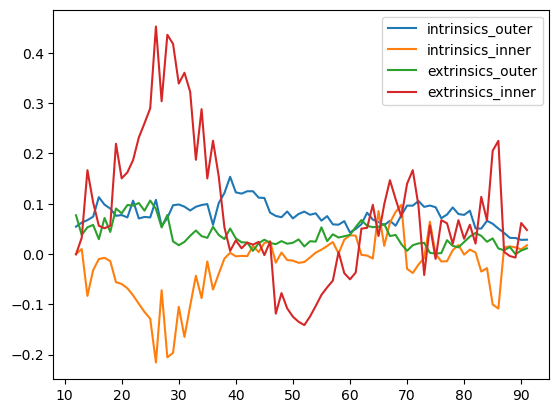

In [11]:
# Plot data['intrinsics_outer'] and data['intrinsics_inner'] vs filenames
filenames = [i for i in range(12, 92)]
plt.plot(filenames, data['intrinsics_outer'], label='intrinsics_outer')
plt.plot(filenames, data['intrinsics_inner'], label='intrinsics_inner')
plt.plot(filenames, data['extrinsics_outer'], label='extrinsics_outer')
plt.plot(filenames, data['extrinsics_inner'], label='extrinsics_inner')
plt.legend()